In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

import cv2
import numpy as np
import time

In [2]:
# GPU 확인
!nvidia-smi

Wed Oct 13 07:28:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# 이미지 다운로드
!mkdir /content/data
!wget -O ./data/test_image.jpg https://miro.medium.com/max/1000/1*bk6ObyKmW_uxSQJ3_zQEJA.jpeg

--2021-10-13 07:33:25--  https://miro.medium.com/max/1000/1*bk6ObyKmW_uxSQJ3_zQEJA.jpeg
Resolving miro.medium.com (miro.medium.com)... 162.159.153.4, 162.159.152.4, 2606:4700:7::a29f:9904, ...
Connecting to miro.medium.com (miro.medium.com)|162.159.153.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154993 (151K) [image/jpeg]
Saving to: ‘./data/test_image.jpg’

./data/test_image.j 100%[===================>] 151.36K  --.-KB/s    in 0.02s   

2021-10-13 07:33:26 (8.97 MB/s) - ‘./data/test_image.jpg’ saved [154993/154993]



## TF Hub에서 SSD Inference 모델 다운로드 후 Inference 수행
- 로딩된 모델은 바로 원본 이미지로 Object Detection이 가능. 입력 이미지 값으로 numpy array, tensor 모두 가능하며 uint8로 구성 필요.
- inference 결과는 dictionary 형태로 반환되며, 개별 key값은 Object Detection 모델에 따라 달라질 수 있음. 개별 value는 tensor로 되어 있음(4차원).
- inference 반환된 bbox 좌표는 이미지 사이즈 대비 스케일링 된 0~1 사이 값이며 ymin, xmin, ymax, xmax 형태로 반환되므로 반드시 주의 필요

In [4]:
# pretrained ssd model 로딩
module_handle = 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2'
detector_model = hub.load(module_handle)

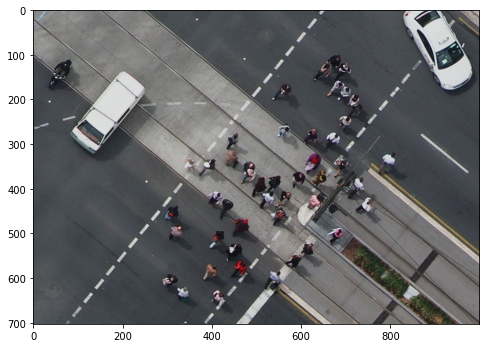

In [5]:
img_arr = cv2.imread('/content/data/test_image.jpg')
img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_arr)
plt.show()

In [7]:
# 4차원 numpy array로 변환
img_arr_np = img_arr[np.newaxis, ...]
print(f"image shape: {img_arr_np.shape}, dtype: {img_arr_np.dtype}")

start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행.
result = detector_model(img_arr_np)
print(f"inference time: {time.time()-start_time}")

image shape: (1, 703, 1000, 3), dtype: uint8
inference time: 0.04094505310058594


In [8]:
# 4차원 tensor로 변환
img_tensor = tf.convert_to_tensor(img_arr, dtype=tf.uint8)
img_tensor = img_tensor[tf.newaxis, ...]
print(f"image shape: {img_tensor.shape}, dtype: {img_tensor.dtype}")

start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행.
result = detector_model(img_tensor)
print(f"inference time: {time.time()-start_time}")

image shape: (1, 703, 1000, 3), dtype: <dtype: 'uint8'>
inference time: 0.03539085388183594


In [9]:
result

{'detection_anchor_indices': <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
 array([[ 831.,  480., 1862.,  531.,  714.,  258.,  167.,  549.,  174.,
          657.,  609.,  546.,  879.,  324.,  990.,  534.,  555.,  207.,
          666.,  987.,  648.,  381.,  432.,  699.,  540.,  537.,  660.,
          777.,  315.,  597.,  429.,  438.,  552.,  888.,  267.,  435.,
          606.,  264.,  717.,  762.,  600.,  927.,  603.,  663.,  885.,
          423.,  930.,  666.,  876.,  654.,  714.,  777.,  558.,  167.,
          759.,  110.,  819.,  296.,  210., 1760.,  477.,  609.,  492.,
          822., 1724.,  828.,  654.,  765.,  942.,  231.,  657.,  326.,
          591.,  708., 1736.,  642.,  702.,  708., 1911., 1790.,  936.,
          726.,  882.,  774.,  933.,  723.,  696.,  489.,  666.,  663.,
          353.,  939.,  495.,  324.,  777.,  831.,  879.,  720.,  474.,
          837.]], dtype=float32)>,
 'detection_boxes': <tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
 array([[[0.73721266,

In [10]:
print(result.keys())
# detect 결과는 100개를 기본으로 Detect 함(즉 Detect된 오브젝트는 무조건 100개. 그래서 tensor(array)는 100개 단위)
print(result['detection_boxes'].shape, result['detection_classes'].shape, result['num_detections'].shape, result['detection_scores'].shape)

dict_keys(['raw_detection_boxes', 'detection_anchor_indices', 'detection_classes', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_scores', 'num_detections', 'detection_boxes'])
(1, 100, 4) (1, 100) (1,) (1, 100)


In [11]:
# detect된 object들은 detection score가 높은 순으로 array값을 순차적으로 채움. 
print('#### detection_classes #####')
print(result['detection_classes'],'\n')
print('#### detection_scores #####')
print(result['detection_scores'])

#### detection_classes #####
tf.Tensor(
[[ 1.  1.  1.  1.  1.  1. 77.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  3.  1.  1.  4.  3.  1. 75.
   1.  3.  1. 77.  1.  1.  1.  3.  1.  1.  1.  1.  4.  1.  1.  1.  4.  1.
   1.  1.  1.  1.  1. 28. 41.  1.  1.  1.  1.  1.  1.  1.  1.  1.  4.  3.
  84.  1.  1.  4.  8.  3. 10.  1.  1.  1.]], shape=(1, 100), dtype=float32) 

#### detection_scores #####
tf.Tensor(
[[0.677444   0.6642207  0.6275905  0.6187013  0.60781085 0.6017544
  0.59606063 0.5958078  0.59062433 0.58101463 0.5665838  0.5663808
  0.559792   0.55558926 0.5422876  0.5410848  0.5403648  0.54036
  0.53791845 0.53639287 0.5352442  0.5343554  0.5246403  0.5240007
  0.5191903  0.514334   0.51212674 0.49893072 0.49869356 0.49716964
  0.49372628 0.48866254 0.48672912 0.4850068  0.47916415 0.4730842
  0.47197363 0.4697252  0.46866524 0.46538043 0.46061906 0.45869517
  0.

In [12]:
# bounding box 좌표는 ymin, xmin, ymax, xmax 순서로 반환됨. y가 먼저, x가 나중에 나오므로 반드시 주의해야 함. 
# 좌표 값은 원본 이미지의 width, height로 0~1 사이값으로 정규화됨. 
print('#### detection_boxes #####')
print(result['detection_boxes'])

#### detection_boxes #####
tf.Tensor(
[[[0.73721266 0.5871197  0.80400133 0.62958324]
  [0.39050573 0.42240486 0.50233364 0.46623287]
  [0.07315832 0.09221664 0.93703276 0.8853456 ]
  [0.4755865  0.35026726 0.526221   0.3790982 ]
  [0.6257898  0.5363675  0.69380873 0.5718128 ]
  [0.23599206 0.5395342  0.28151533 0.5780008 ]
  [0.         0.8341201  0.26613784 0.9826911 ]
  [0.47426572 0.6461855  0.55566126 0.6875528 ]
  [0.16484219 0.05332366 0.24107537 0.08876418]
  [0.55840874 0.52846974 0.63536024 0.5673756 ]
  [0.53780836 0.6968405  0.5890941  0.73328996]
  [0.46060315 0.60331607 0.5403794  0.64367163]
  [0.7762426  0.44122255 0.8572984  0.48278052]
  [0.26466516 0.6900036  0.32399872 0.73832136]
  [0.89820236 0.39667398 0.9489898  0.4308433 ]
  [0.47860768 0.37316257 0.53077644 0.4037462 ]
  [0.4621963  0.76085514 0.53074163 0.8047958 ]
  [0.1532534  0.63364196 0.22987366 0.696252  ]
  [0.58877766 0.7151712  0.6446521  0.7550533 ]
  [0.87491125 0.3154396  0.9394892  0.3566558 ]
  

In [19]:
for key,value in result.items():
    print(value.numpy())

[[[-9.0342201e-04  9.8334067e-04  4.6731591e-02  4.2100266e-02]
  [-2.1203497e-02 -7.7001929e-02  7.5277053e-02  1.4212596e-01]
  [-6.8882383e-02 -1.9189317e-02  1.8112484e-01  8.6568356e-02]
  ...
  [ 1.7871609e-01  1.4591545e-02  8.0417526e-01  9.8589206e-01]
  [ 2.5359750e-02  1.6322184e-01  9.8206103e-01  8.0986679e-01]
  [ 5.1477700e-02  8.6889654e-02  9.6294427e-01  8.8998973e-01]]]
[[ 831.  480. 1862.  531.  714.  258.  167.  549.  174.  657.  609.  546.
   879.  324.  990.  534.  555.  207.  666.  987.  648.  381.  432.  699.
   540.  537.  660.  777.  315.  597.  429.  438.  552.  888.  267.  435.
   606.  264.  717.  762.  600.  927.  603.  663.  885.  423.  930.  666.
   876.  654.  714.  777.  558.  167.  759.  110.  819.  296.  210. 1760.
   477.  609.  492.  822. 1724.  828.  654.  765.  942.  231.  657.  326.
   591.  708. 1736.  642.  702.  708. 1911. 1790.  936.  726.  882.  774.
   933.  723.  696.  489.  666.  663.  353.  939.  495.  324.  777.  831.
   879.  720.  4

## inference 결과를 이미지로 시각화

In [13]:
# 1부터 91까지의 COCO Class id 매핑. 
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

person: 0.6774
person: 0.6642
person: 0.6276
person: 0.6187
person: 0.6078
person: 0.6018
cell phone: 0.5961
person: 0.5958
person: 0.5906
person: 0.5810
person: 0.5666
person: 0.5664
person: 0.5598
person: 0.5556
person: 0.5423
person: 0.5411
person: 0.5404
person: 0.5404
person: 0.5379
person: 0.5364
person: 0.5352
person: 0.5344
person: 0.5246
person: 0.5240
person: 0.5192
person: 0.5143
person: 0.5121


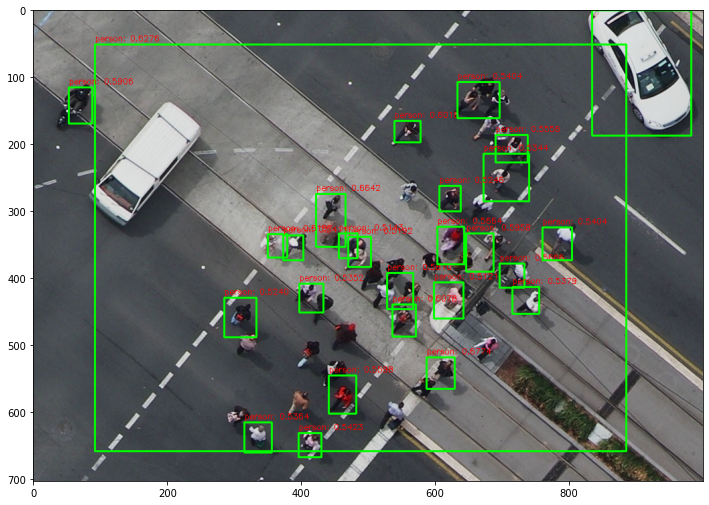

In [29]:
img_array = cv2.cvtColor(cv2.imread('/content/data/test_image.jpg'), cv2.COLOR_BGR2RGB)

# scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
height = img_array.shape[0]
width = img_array.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img_array.copy()

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(255, 0, 0)


# cv2로 만들어진 numpy image array를 tensor로 변환
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]

# inference
result = detector_model(img_tensor)

# result 내부의 value를 numpy 로 변환. 
result = {key:value.numpy() for key,value in result.items()}

score_threshold = 0.5
object_default_count = 100

# detected 된 object들을 iteration 하면서 정보 추출
for i in range(min(result['detection_scores'][0].shape[0], object_default_count)):
    # detection score를 iteration시 마다 높은 순으로 추출하고 score_threshold보다 낮으면 loop 중단.
    score = result['detection_scores'][0, i]
    if score < score_threshold:
        break
    
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = result['detection_boxes'][0, i]
    # box는 ymin, xmin, ymax, xmax 순서로 되어 있음
    left = int(box[1]*width)
    top = int(box[0]*height)
    right = int(box[3]*width)
    bottom = int(box[2]*height)

    class_id = result['detection_classes'][0, i]
    caption = f"{labels_to_names[class_id]}: {score:.4f}"
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (left, top), (right, bottom), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (left, top-5), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4, color=red_color, thickness=1)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(draw_img)
plt.show()

In [52]:
def get_detected_img(model, img_array, score_threshold, object_show_count=100, is_print=True):   
    # scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
    height = img_array.shape[0]
    width = img_array.shape[1]
    # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
    draw_img = img_array.copy()

    # bounding box의 테두리와 caption 글자색 지정
    green_color=(0, 255, 0)
    red_color=(255, 0, 0)

    # cv2로 만들어진 numpy image array를 tensor로 변환
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
    #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

    # ssd+mobilenet v2 모델을 다운로드 한 뒤 inference 수행. 
    start_time = time.time()
    result = model(img_tensor)
    # result 내부의 value를 numpy 로 변환. 
    result = {key:value.numpy() for key,value in result.items()}

    # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
    for i in range(min(result['detection_scores'][0].shape[0], object_show_count)):
        # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
        score = result['detection_scores'][0, i]
        if score < score_threshold:
            break
        # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
        box = result['detection_boxes'][0, i]

        
        # box는 ymin, xmin, ymax, xmax 순서로 되어 있음
        left = box[1] * width
        top = box[0] * height
        right = box[3] * width
        bottom = box[2] * height

        # class id 추출하고 class 명으로 매핑
        class_id = result['detection_classes'][0, i]
        caption = f"{labels_to_names[class_id]}: {score:.4f}"
        
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

    if is_print:
        print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

    return draw_img

In [31]:
detector_model = hub.load('https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2')

person: 0.6774
person: 0.6642
person: 0.6276
person: 0.6187
person: 0.6078
person: 0.6018
cell phone: 0.5961
person: 0.5958
person: 0.5906
person: 0.5810
person: 0.5666
person: 0.5664
person: 0.5598
person: 0.5556
person: 0.5423
person: 0.5411
person: 0.5404
person: 0.5404
person: 0.5379
person: 0.5364
person: 0.5352
person: 0.5344
person: 0.5246
person: 0.5240
person: 0.5192
person: 0.5143
person: 0.5121
Detection 수행시간: 0.05 초


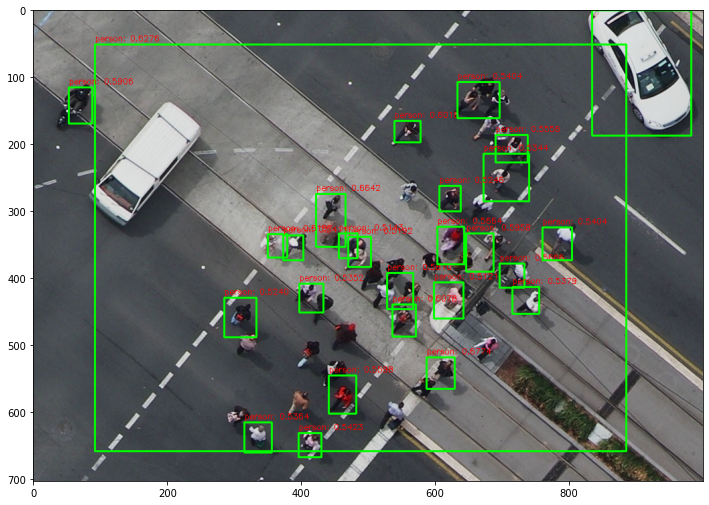

In [35]:
img_array = cv2.cvtColor(cv2.imread('/content/data/test_image.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold=0.5, object_show_count=100, is_print=True)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(draw_img)
plt.show()

## Video Inference 수행

In [36]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2021-10-13 08:42:48--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2021-10-13 08:42:48--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2021-10-13 08:42:48--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [53]:
def do_detected_video(model, input_path, output_path, score_threshold, is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        img_frame = cv2.cvtColor(img_frame, cv2.COLOR_BGR2RGB)    
        img_frame = get_detected_img(model, img_frame, score_threshold=score_threshold, object_show_count=100, is_print=is_print)
        img_frame = cv2.cvtColor(img_frame, cv2.COLOR_RGB2BGR)

        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [54]:
do_detected_video(detector_model, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_02.mp4', 0.5, True)

총 Frame 갯수: 58
Detection 수행시간: 0.04 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.03 초
Detection 수행시간: 0.0